In [12]:
# 실습용 데이터 패키지
from torchvision.datasets import FashionMNIST

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch

# 기계학습 모델 패키지
from sklearn.neural_network import MLPClassifier

# 시각화
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# 예측 평가 지표 패키지
from sklearn.metrics import accuracy_score, confusion_matrix

# 예측 결과 시각화 custom 함수
def plot_confusion_matrix(cm, classes,title, cmap=plt.cm.Blues):
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black",fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 기타
import warnings, itertools, time
warnings.filterwarnings(action='ignore')

In [13]:
# 한글 설정
import matplotlib.font_manager as fm
import matplotlib as mp
font_dirs = './'
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rc('font', family='NanumGothic')

mp.rcParams['font.size'] = 15
mp.rcParams['axes.unicode_minus'] = False

In [14]:
# Fashion MNIST 데이터를 저장할 directory
download_root = './'

# 데이터 scaling을 위한 요소
fasion_mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 데이터 형태를 Pytorch에 적합한 형태로 바꾸어 줌
    transforms.Normalize((0.0,), (1.0,)) # feature들의 평균과 표준편차를 0과 1로 scaling 해줌
])

#FashionMNIST 훈련 데이터셋 다운로드
dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)

# 훈련 데이터셋을 50000개(학습용) / 10000개(검증용)으로 분리
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

# 테스트 데이터셋 다운로드
test_dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=False, download=True)

## Using sklearn

In [16]:
model = MLPClassifier(random_state=0,hidden_layer_sizes=(300,150),
                      activation="relu",solver='adam',batch_size=100,
                      learning_rate='constant',learning_rate_init=0.001,
                      verbose=True,early_stopping=True,validation_fraction=10000/60000,
                      n_iter_no_change=5)

In [17]:
start = time.time()  # 모델 학습 시작 시간 저장 28*28=784
model.fit(dataset.data.numpy().reshape(60000,784),dataset.targets.numpy()) # 모델 학습
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Iteration 1, loss = 3.10794375
Validation score: 0.805700
Iteration 2, loss = 0.76932434
Validation score: 0.808200
Iteration 3, loss = 0.52016854
Validation score: 0.828700
Iteration 4, loss = 0.43493388
Validation score: 0.841900
Iteration 5, loss = 0.39619939
Validation score: 0.848500
Iteration 6, loss = 0.38127267
Validation score: 0.854300
Iteration 7, loss = 0.36746608
Validation score: 0.850800
Iteration 8, loss = 0.35800889
Validation score: 0.859800
Iteration 9, loss = 0.35746250
Validation score: 0.873800
Iteration 10, loss = 0.34863168
Validation score: 0.858900
Iteration 11, loss = 0.34420032
Validation score: 0.860400
Iteration 12, loss = 0.34083753
Validation score: 0.867900
Iteration 13, loss = 0.33418047
Validation score: 0.855700
Iteration 14, loss = 0.32853389
Validation score: 0.869600
Iteration 15, loss = 0.32511617
Validation score: 0.862400
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
time : 44.97891712188721


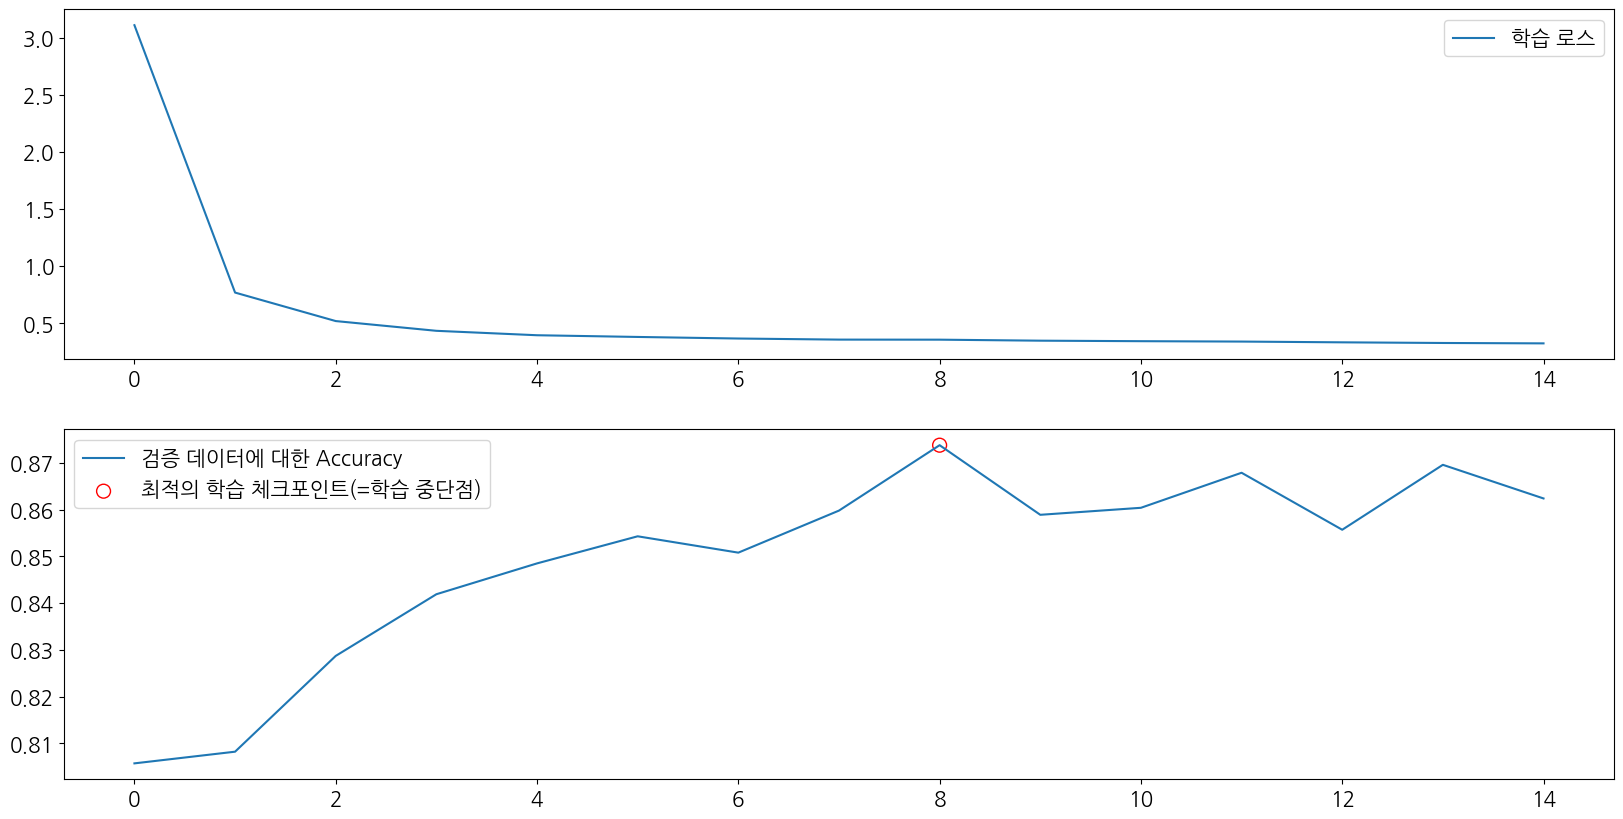

In [18]:
# 모델의 training loss
train_loss = model.loss_curve_

# 그래프 배경화면 만들기
f, axs = plt.subplots(2,1,figsize=(20,10))

# 학습로스 변동 관찰하기
axs[0].plot(train_loss,label='학습 로스')
axs[0].legend()

# 검증용 데이터에 대한 Accuracy 변동 관찰하기
axs[1].plot(model.validation_scores_,label='검증 데이터에 대한 Accuracy')
axs[1].scatter(np.argmax(model.validation_scores_),np.max(model.validation_scores_),s=100,facecolors='none',edgecolors='r',
              label='최적의 학습 체크포인트(=학습 중단점)')
axs[1].legend()
plt.show()

In [19]:
# 예측 Accuracy 확인하기
train_accuracy = accuracy_score(y_pred=model.predict(dataset.data.numpy().reshape(60000,-1)),y_true=dataset.targets.numpy())
test_accuracy = accuracy_score(y_pred=model.predict(test_dataset.data.numpy().reshape(10000,-1)),y_true=test_dataset.targets.numpy())
print(f"훈련 데이터셋 정확도: {train_accuracy:.3f}",f"테스트용 데이터셋 정확도: {test_accuracy:.3f}",sep='  |  ') 

훈련 데이터셋 정확도: 0.885  |  테스트용 데이터셋 정확도: 0.856


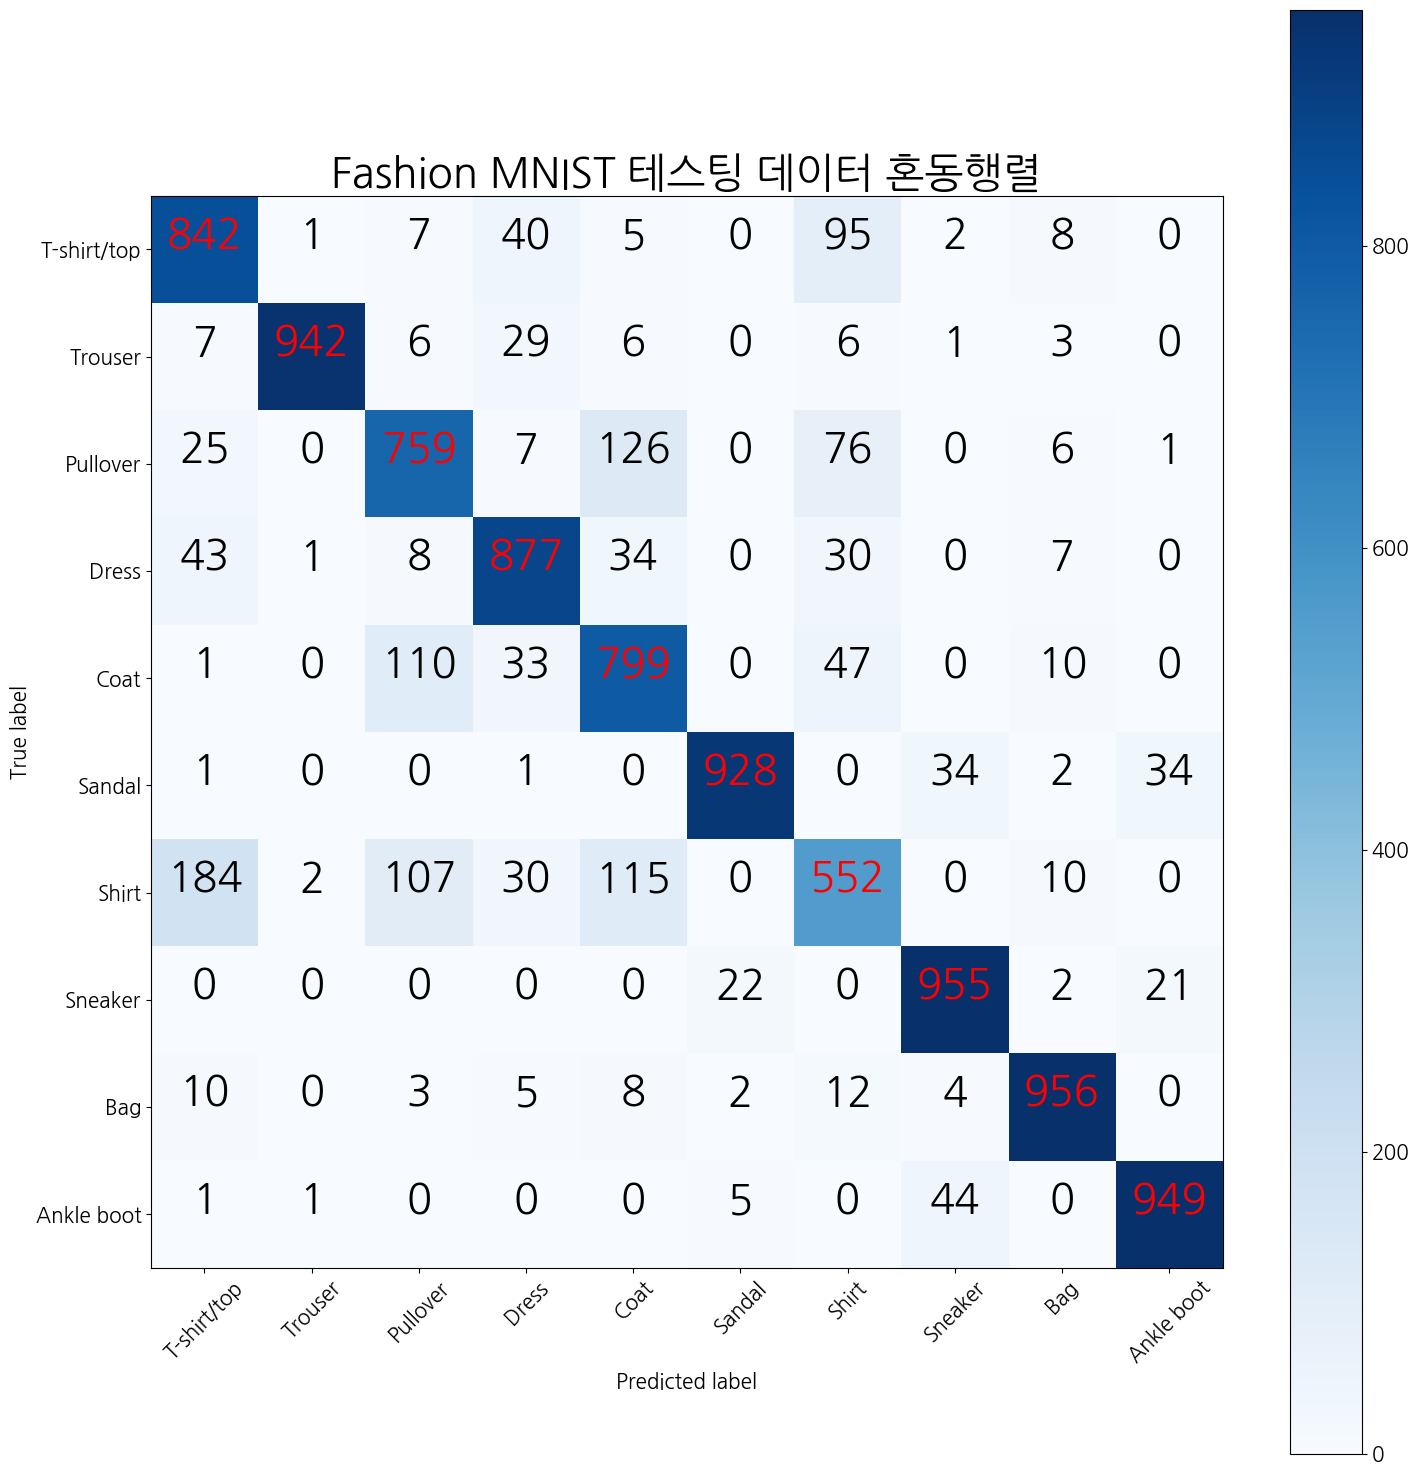

In [20]:
confusion_matrix_ = confusion_matrix(y_pred=model.predict(test_dataset.data.numpy().reshape(10000,-1)),y_true=test_dataset.targets.numpy())
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='Fashion MNIST 테스팅 데이터 혼동행렬')

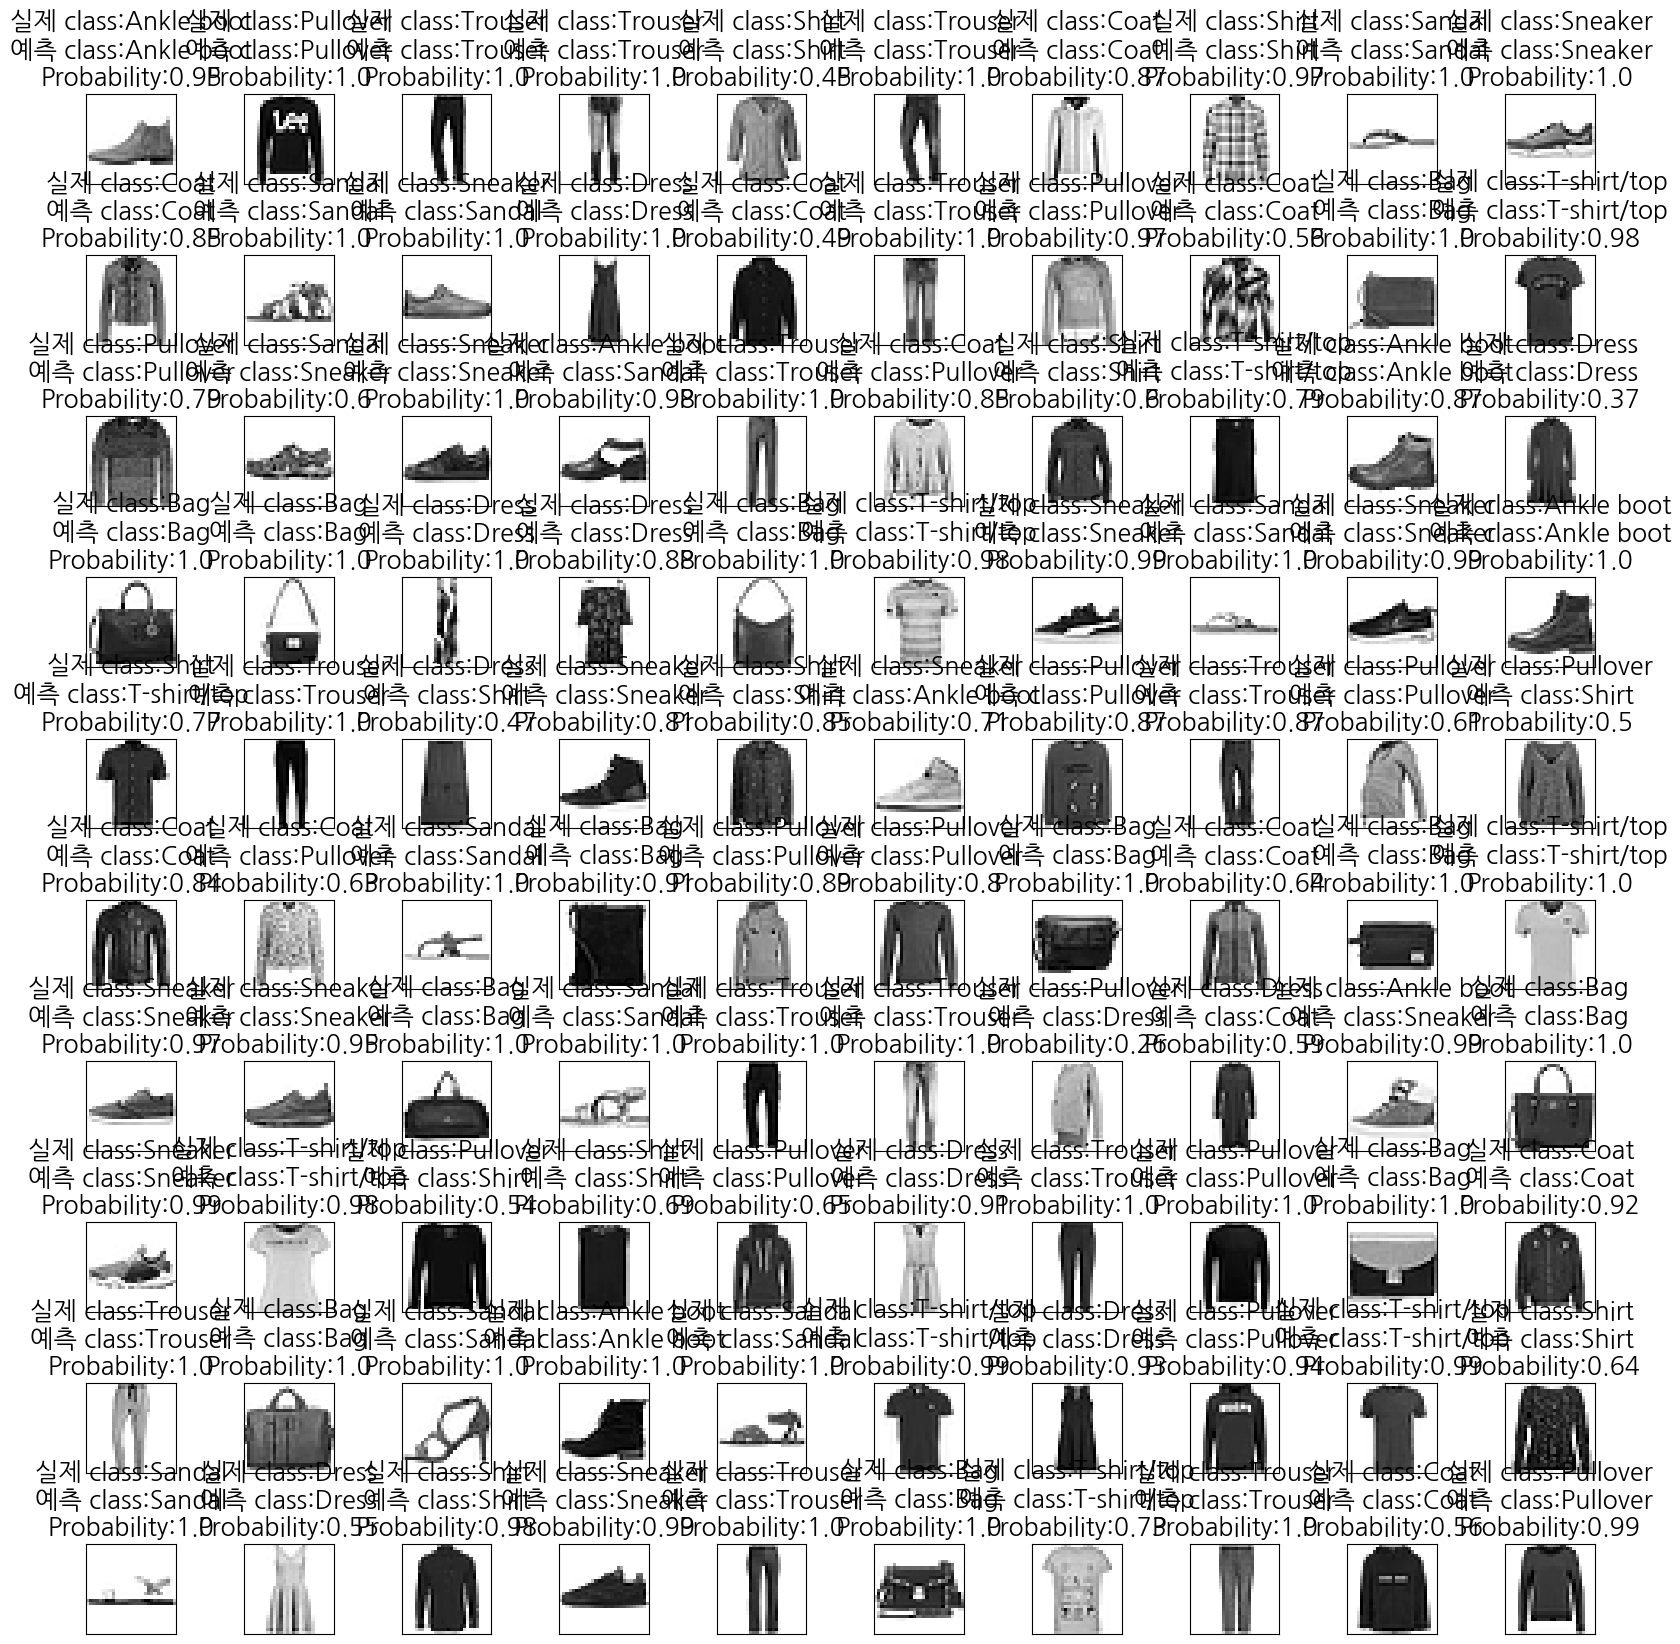

In [47]:
for_visualization_test_x = test_dataset.data.numpy()[:100]
for_visualization_test_y = test_dataset.targets.numpy()[:100]

f ,axs = plt.subplots(10,10,figsize=(20,20))
plt.subplots_adjust(hspace=0.8)
for i in range(10):
    for j in range(10):
        
        x_data = for_visualization_test_x[10*i+j]
        y_data = for_visualization_test_y[10*i+j]
        real_class = dataset.classes[y_data]
        predicted_class = dataset.classes[np.argmax(model.predict_proba(x_data.reshape(1,-1)))]
        predicted_prob = np.max(model.predict_proba(x_data.reshape(1,-1))).round(2)
        
        # x, y 축의 지점 표시를 안함
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

        # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
        axs[i,j].set_title(f"실제 class:{real_class}\n예측 class:{predicted_class}\nProbability:{predicted_prob}")

        # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
        # 이 2차원 배열을 그레이스케일 이미지로 출력
        axs[i,j].imshow(x_data.reshape((28, 28)),cmap=plt.cm.gray_r)
 
plt.show()